In [0]:
from __future__ import print_function, division
import os
import torch
import os
import torch
from torch import nn
import pandas as pd
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tqdm

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode

In [0]:
import tarfile
# fname = 'data.tar.gz'
# if (fname.endswith("tar.gz")):
#     tar = tarfile.open(fname, "r:gz")
#     tar.extractall()
#     tar.close()

In [10]:
from tensorflow.python.client import device_lib; device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3777388919199452197, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1386550153102533408
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4695393814168316820
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 8259990324
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15624082629660893005
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

class DenoisingDataset(Dataset):

    def __init__(self, data_dir, transform=None, train=True):
        self.train= train 
        self.x_path = os.path.join(data_dir, 'clean')
        self.y_path = os.path.join(data_dir, 'distorted')
        self.x_test_path = os.path.join(data_dir, 'test_distorted')
        self.x_files_paths = glob.glob(os.path.join(self.x_path, '*.jpg'))
        self.y_files_paths = glob.glob(os.path.join(self.y_path, '*.jpg'))
        self.x_test_files_paths = glob.glob(os.path.join(self.x_test_path, '*.jpg'))
        self.transform = transform
        self.train_data = []
        self.test_data = []
        self.labels_data = []

    def __len__(self):
        if self.train:
          return len(self.x_files_paths)
        else:
          return len(self.x_test_files_paths)

    def __getitem__(self, idx):
        if self.train: 
            x_img_name, y_img_name =  self.x_files_paths[idx], self.y_files_paths[idx]
            x_image, y_image = io.imread(x_img_name), io.imread(y_img_name)
            x = self.transform(x_image)
            y = self.transform(y_image)
            self.train_data.append(x)
            self.labels_data.append(y)
            return x,y
            
        else:
            x_test_img_name =  self.x_test_files_paths[idx]
            x_test_image = io.imread(x_test_img_name)
            x = self.transform(x_test_image)
            self.test_data.append(x)
            return x
        
    def get_train_data(self, num):
        return torch.stack(self.train_data[:num]), torch.stack(self.labels_data[:num])
    
    def get_test_data(self, num):
        return torch.stack(self.test_data[:num])


def show_img(image):
#     plt.imshow(image)
#     print(image)
    plt.imshow(image.permute(1, 2, 0).type(torch.FloatTensor)  )
    plt.pause(0.001)  # pause a bit so that plots are updated
    

def save_result(images: np.ndarray, out_path: str):
    
    assert images.shape == (400, 3, 48, 48)
    
    flat_img = images.reshape(400, -1)
    n_rows = np.prod(images.shape)
    
    y_with_id = np.concatenate([np.arange(n_rows).reshape(-1, 1), flat_img.reshape(n_rows, 1)], axis=1)
    np.savetxt(out_path, y_with_id, delimiter=",", fmt=['%d', '%.4f'], header="id,expetced", comments='')

In [12]:
train_dataset = DenoisingDataset('data', 
                                 transform=transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                ]))
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print(next(iter(train_loader))[0].shape)

torch.Size([32, 3, 48, 48])


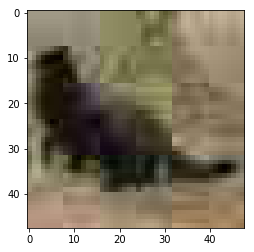

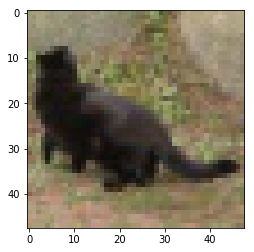

In [13]:

show_img(train_dataset.get_train_data(5)[1][3])
show_img(train_dataset.get_train_data(5)[0][3])

In [0]:
class ConvVAutoencoder(nn.Module):
    def __init__(self):
        super(ConvVAutoencoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(16)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(12 * 12 * 16, 2048)
        self.fc_bn1 = nn.BatchNorm1d(2048)
        self.fc21 = nn.Linear(2048, 2048)
        self.fc22 = nn.Linear(2048, 2048)

        # Sampling vector
        self.fc3 = nn.Linear(2048, 2048)
        self.fc_bn3 = nn.BatchNorm1d(2048)
        self.fc4 = nn.Linear(2048, 12 * 12 * 16)
        self.fc_bn4 = nn.BatchNorm1d(12 * 12 * 16)

        # Decoder
        self.conv5 = nn.ConvTranspose2d(16, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias=False)

        self.relu = nn.ReLU()
    def forward(self, x):
        conv1 = self.relu(self.bn1(self.conv1(x)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3))).view(-1, 12 * 12 * 16 )

        fc1 = self.relu(self.fc_bn1(self.fc1(conv4)))
        mu = self.fc21(fc1)
        std = self.fc22(fc1)

        std = logvar.mul(0.5).exp_()
        eps = Variable(std.data.new(std.size()).normal_())
        z = eps.mul(std).add_(mu)
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3))).view(-1, 12, 12, 16)

        conv5 = self.relu(self.bn5(self.conv5(fc4)))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        out = self.conv8(conv7).view(-1, 3, 48, 48)
        return fc4, out

In [0]:
# Create the neural network
def AE(x_dict, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('autoencoder', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['noise']
        
        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        conv1 = tf.layers.conv2d(x, 32, 3, activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(conv1, 32, 3, activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(conv2, 2, 2)
        conv3 = tf.layers.conv2d(pool1, 64, 3, activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(conv3, 2, 2)
        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(pool2)
        fc1=tf.reshape(fc1,shape=[-1,1,1,1600])
        conv_0T = tf.layers.Conv2DTranspose(128,(1, 1),activation=tf.nn.relu)(fc1)#1*1
        conv_1T = tf.layers.Conv2DTranspose(64,(3, 3), activation=tf.nn.relu)(conv_0T)#3*3
        conv_2T = tf.layers.Conv2DTranspose(64,(3, 3), activation=tf.nn.relu)(conv_1T)#5*5
        conv_3T = tf.layers.Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation=tf.nn.relu)(conv_2T)#10*10
        conv_4T = tf.layers.Conv2DTranspose(48,(3, 3), activation=tf.nn.relu)(conv_3T)#12*12
        conv_5T = tf.layers.Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation=tf.nn.relu)(conv_4T)#24*24
        conv_6T = tf.layers.Conv2DTranspose(16,(3, 3), activation=tf.nn.relu)(conv_5T)#26*26
        out = tf.layers.Conv2DTranspose(1,(3, 3),activation=tf.nn.sigmoid)(conv_6T)#28*28
    #print(tf.layer.all_layers)
    return out
  
def AE_loss(x_reconstructed,x_true):
  encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                       + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
  encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
  return tf.reduce_mean(encode_decode_loss)

In [0]:
# inputs = Input(shape=(28, 28, 1))
#     x = Conv2D(16, 3, activation='relu', padding='same')(inputs)
#     x = MaxPooling2D(padding='same')(x)
#     x = Conv2D( 8, 3, activation='relu', padding='same')(x)
#     x = MaxPooling2D(padding='same')(x)
#     x = Conv2D( 8, 3, activation='relu', padding='same')(x)
#     encoded = MaxPooling2D(padding='same')(x)    
    
#     # decoding
#     x = Conv2D( 8, 3, activation='relu', padding='same')(encoded)
#     x = UpSampling2D()(x)
#     x = Conv2D( 8, 3, activation='relu', padding='same')(x)
#     x = UpSampling2D()(x)
#     x = Conv2D(16, 3, activation='relu')(x) # <= padding='valid'!
#     x = UpSampling2D()(x)
#     decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)
class ConvAutoencoder(nn.Module):
    def __init__(self, ks):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, (ks + 1,ks + 1), padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 8, (ks,ks), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(8, 3, (ks - 1,ks - 1), padding=1),
            nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
            
            
            
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=3,out_channels=8, kernel_size=(ks  - 1,ks -1 ), padding=1),
            nn.ReLU(inplace=True),
#             nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(in_channels=8,out_channels=16, kernel_size=(ks ,ks), padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(16, 3, (ks + 1,ks + 1), padding=1),
            nn.ReLU()
            
            
            
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        print('decoded: ', decoded.shape)
        return encoded, decoded

0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
Epoch:  0 | train loss: 0.0760
decoded:  torch.Size([1, 3, 48, 48])


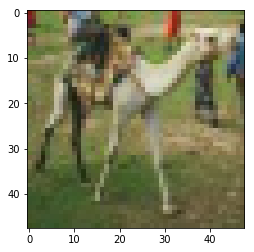

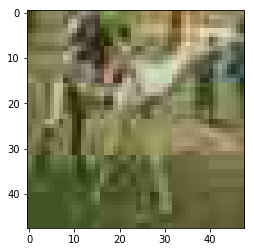

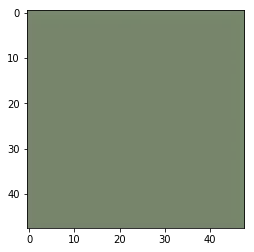

3it [00:00,  2.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


5it [00:01,  3.83it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


7it [00:01,  5.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


9it [00:01,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


11it [00:01,  7.02it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


13it [00:02,  7.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


15it [00:02,  7.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


17it [00:02,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


19it [00:02,  7.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


21it [00:03,  7.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


23it [00:03,  7.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


25it [00:03,  7.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


27it [00:04,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


29it [00:04,  7.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


31it [00:04,  7.77it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


33it [00:04,  7.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


35it [00:05,  7.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


37it [00:05,  7.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


39it [00:05,  7.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


41it [00:05,  7.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


43it [00:06,  7.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


45it [00:06,  7.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


47it [00:06,  7.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


49it [00:06,  7.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


51it [00:07,  7.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


52it [00:07,  7.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


55it [00:07,  7.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


57it [00:08,  7.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


59it [00:08,  7.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


61it [00:08,  7.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


63it [00:08,  7.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


65it [00:09,  7.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


67it [00:09,  7.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


69it [00:09,  7.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


71it [00:09,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


73it [00:10,  7.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


75it [00:10,  7.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


77it [00:10,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


79it [00:10,  7.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


81it [00:11,  7.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


83it [00:11,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


85it [00:11,  7.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


87it [00:11,  7.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


89it [00:12,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


91it [00:12,  7.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


93it [00:12,  7.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


95it [00:13,  7.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


97it [00:13,  7.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


99it [00:13,  7.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


100it [00:13,  7.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  0 | train loss: 0.0112
decoded:  torch.Size([1, 3, 48, 48])


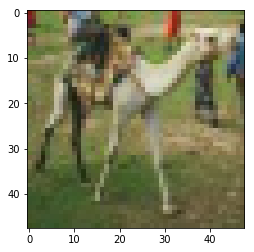

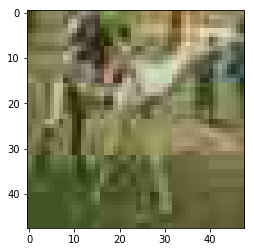

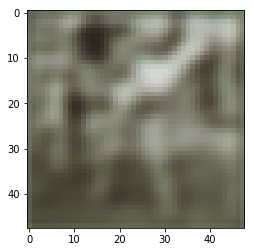

103it [00:14,  4.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


105it [00:15,  5.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


107it [00:15,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


109it [00:15,  6.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


111it [00:15,  7.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


113it [00:16,  7.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


115it [00:16,  7.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


116it [00:16,  7.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


119it [00:16,  7.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


121it [00:17,  7.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


123it [00:17,  7.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


125it [00:17,  7.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


127it [00:17,  7.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


129it [00:18,  7.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


131it [00:18,  7.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


133it [00:18,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


135it [00:18,  7.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


137it [00:19,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


139it [00:19,  7.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


141it [00:19,  7.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


143it [00:20,  7.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


145it [00:20,  7.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


147it [00:20,  7.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


149it [00:20,  7.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


151it [00:21,  7.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


153it [00:21,  7.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


155it [00:21,  7.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


157it [00:21,  7.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


159it [00:22,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


161it [00:22,  7.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


163it [00:22,  7.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


165it [00:22,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


167it [00:23,  7.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


169it [00:23,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


171it [00:23,  7.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


173it [00:23,  7.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


175it [00:24,  7.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


177it [00:24,  7.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


179it [00:24,  7.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


181it [00:25,  7.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


183it [00:25,  7.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


185it [00:25,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


187it [00:25,  7.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


189it [00:26,  7.77it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


191it [00:26,  7.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


193it [00:26,  7.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


195it [00:26,  7.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


197it [00:27,  7.83it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


199it [00:27,  7.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


200it [00:27,  7.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  0 | train loss: 0.0095
decoded:  torch.Size([1, 3, 48, 48])


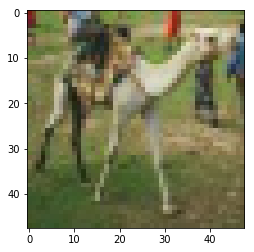

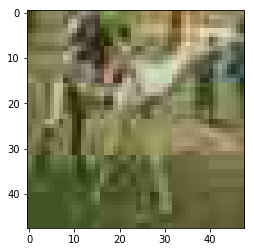

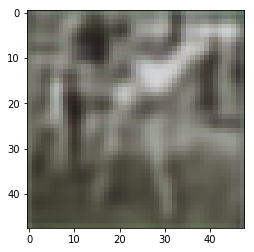

203it [00:28,  4.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


205it [00:28,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


207it [00:28,  6.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


209it [00:29,  7.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


211it [00:29,  7.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


213it [00:29,  7.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


215it [00:30,  7.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


217it [00:30,  7.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


219it [00:30,  7.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


221it [00:30,  7.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


223it [00:31,  7.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


225it [00:31,  7.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


227it [00:31,  7.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


229it [00:31,  7.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


231it [00:32,  7.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


233it [00:32,  7.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


235it [00:32,  7.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


237it [00:32,  7.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


239it [00:33,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


240it [00:33,  7.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


243it [00:33,  7.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


245it [00:34,  7.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


247it [00:34,  7.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


248it [00:34,  7.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


251it [00:34,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


253it [00:35,  7.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


255it [00:35,  7.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


257it [00:35,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


259it [00:35,  7.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


261it [00:36,  7.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


263it [00:36,  7.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


265it [00:36,  7.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


267it [00:36,  7.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


269it [00:37,  7.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


271it [00:37,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


273it [00:37,  7.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


275it [00:37,  7.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


276it [00:38,  7.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


279it [00:38,  7.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


281it [00:38,  7.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


283it [00:39,  7.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


285it [00:39,  7.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


287it [00:39,  7.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


289it [00:39,  7.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


291it [00:40,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


293it [00:40,  7.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


295it [00:40,  7.96it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


297it [00:40,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


299it [00:41,  7.77it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


300it [00:41,  7.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  0 | train loss: 0.0092
decoded:  torch.Size([1, 3, 48, 48])


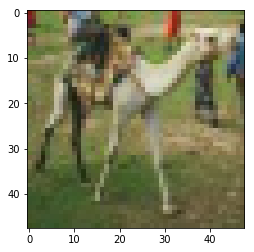

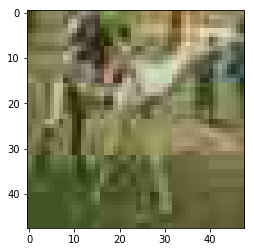

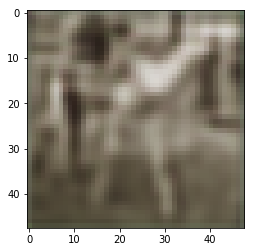

303it [00:42,  4.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


305it [00:42,  6.01it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


307it [00:42,  6.86it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


309it [00:42,  7.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


311it [00:43,  7.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


313it [00:43,  7.21it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


3it [00:00,  7.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


5it [00:00,  7.83it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


7it [00:00,  7.88it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


9it [00:01,  7.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


11it [00:01,  7.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


13it [00:01,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


15it [00:01,  7.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


17it [00:02,  7.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


19it [00:02,  7.98it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


21it [00:02,  7.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


23it [00:02,  7.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


25it [00:03,  7.88it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


27it [00:03,  7.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


29it [00:03,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


31it [00:03,  7.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


33it [00:04,  7.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


35it [00:04,  7.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


37it [00:04,  7.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


39it [00:05,  7.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


41it [00:05,  7.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


43it [00:05,  7.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


45it [00:05,  7.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


47it [00:06,  7.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


49it [00:06,  7.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


51it [00:06,  7.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


53it [00:06,  7.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


55it [00:07,  7.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


57it [00:07,  7.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


59it [00:07,  7.88it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


61it [00:07,  7.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


63it [00:08,  7.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


65it [00:08,  7.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


67it [00:08,  7.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


69it [00:08,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


71it [00:09,  7.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


73it [00:09,  7.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


75it [00:09,  8.02it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


77it [00:09,  7.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


79it [00:10,  7.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


81it [00:10,  7.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


83it [00:10,  7.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


85it [00:10,  7.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


87it [00:11,  7.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


89it [00:11,  7.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


91it [00:11,  7.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


93it [00:12,  7.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


95it [00:12,  7.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


97it [00:12,  7.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


99it [00:12,  7.97it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


101it [00:13,  7.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


103it [00:13,  7.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


105it [00:13,  7.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


107it [00:13,  7.86it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


109it [00:14,  7.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


111it [00:14,  7.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


113it [00:14,  7.86it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


115it [00:14,  7.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


117it [00:15,  7.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


119it [00:15,  7.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


121it [00:15,  7.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


123it [00:15,  7.92it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


125it [00:16,  7.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


127it [00:16,  7.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


129it [00:16,  7.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


131it [00:16,  7.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


133it [00:17,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


135it [00:17,  7.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


137it [00:17,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


139it [00:17,  7.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


141it [00:18,  7.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


143it [00:18,  8.01it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


145it [00:18,  8.01it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


147it [00:18,  8.00it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


149it [00:19,  7.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


151it [00:19,  7.83it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


153it [00:19,  7.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


155it [00:19,  7.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


157it [00:20,  7.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


159it [00:20,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


161it [00:20,  7.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


163it [00:21,  7.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


164it [00:21,  7.83it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


167it [00:21,  7.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


169it [00:21,  7.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


171it [00:22,  7.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


173it [00:22,  7.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


175it [00:22,  7.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


177it [00:22,  7.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


179it [00:23,  7.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


181it [00:23,  7.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


183it [00:23,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


185it [00:23,  7.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


187it [00:24,  7.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


189it [00:24,  7.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


191it [00:24,  7.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


193it [00:24,  7.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


195it [00:25,  7.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


197it [00:25,  7.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


199it [00:25,  7.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


201it [00:25,  7.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


203it [00:26,  7.86it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


205it [00:26,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


207it [00:26,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


209it [00:27,  7.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


211it [00:27,  7.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


213it [00:27,  7.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


215it [00:27,  7.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


217it [00:28,  7.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


219it [00:28,  7.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


220it [00:28,  7.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


223it [00:28,  7.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


225it [00:29,  7.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


227it [00:29,  7.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


229it [00:29,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


231it [00:29,  7.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


233it [00:30,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


235it [00:30,  7.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


237it [00:30,  7.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


239it [00:30,  7.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


241it [00:31,  7.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


243it [00:31,  7.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


244it [00:31,  7.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


247it [00:31,  7.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


249it [00:32,  7.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


251it [00:32,  7.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


253it [00:32,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


255it [00:33,  7.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


257it [00:33,  7.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


259it [00:33,  7.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


261it [00:33,  7.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


263it [00:34,  7.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


265it [00:34,  7.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


267it [00:34,  7.83it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


269it [00:34,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


271it [00:35,  7.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


273it [00:35,  7.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


275it [00:35,  7.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


277it [00:35,  7.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


279it [00:36,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


281it [00:36,  7.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


283it [00:36,  7.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


285it [00:36,  7.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


287it [00:37,  7.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


289it [00:37,  7.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


291it [00:37,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


292it [00:37,  7.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


294it [00:38,  6.83it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


297it [00:38,  7.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


299it [00:38,  7.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


301it [00:39,  7.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


303it [00:39,  7.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


305it [00:39,  7.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


307it [00:39,  7.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


309it [00:40,  7.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


311it [00:40,  7.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


313it [00:40,  7.70it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])


2it [00:00,  7.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


4it [00:00,  7.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


6it [00:00,  7.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


8it [00:01,  7.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


10it [00:01,  7.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


12it [00:01,  7.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


14it [00:01,  7.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


16it [00:02,  7.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


18it [00:02,  7.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


20it [00:02,  7.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


22it [00:02,  7.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


24it [00:03,  7.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


26it [00:03,  7.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


28it [00:03,  7.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


30it [00:04,  7.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


32it [00:04,  7.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


33it [00:04,  7.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


36it [00:04,  7.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


38it [00:05,  7.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


40it [00:05,  7.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


41it [00:05,  7.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


44it [00:05,  7.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


46it [00:06,  7.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


48it [00:06,  7.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


50it [00:06,  7.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


52it [00:07,  7.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


53it [00:07,  7.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


55it [00:07,  7.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


58it [00:07,  7.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


60it [00:08,  7.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


62it [00:08,  7.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


63it [00:08,  7.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


66it [00:08,  7.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


68it [00:09,  7.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


70it [00:09,  7.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


71it [00:09,  7.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


74it [00:10,  7.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


76it [00:10,  7.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


78it [00:10,  7.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


80it [00:10,  7.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


82it [00:11,  7.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


84it [00:11,  7.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


86it [00:11,  7.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


88it [00:11,  7.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


90it [00:12,  7.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


92it [00:12,  7.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


94it [00:12,  7.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


96it [00:13,  7.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


98it [00:13,  7.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


100it [00:13,  7.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


102it [00:13,  7.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


104it [00:14,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


106it [00:14,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


108it [00:14,  7.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


109it [00:14,  6.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


111it [00:15,  6.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


113it [00:15,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])


114it [00:15,  4.92it/s]

decoded:  torch.Size([32, 3, 48, 48])


115it [00:16,  4.33it/s]

decoded:  torch.Size([32, 3, 48, 48])


116it [00:16,  3.95it/s]

decoded:  torch.Size([32, 3, 48, 48])


117it [00:16,  4.02it/s]

decoded:  torch.Size([32, 3, 48, 48])


118it [00:16,  4.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


120it [00:17,  4.63it/s]

decoded:  torch.Size([32, 3, 48, 48])


121it [00:17,  4.68it/s]

decoded:  torch.Size([32, 3, 48, 48])


122it [00:17,  4.68it/s]

decoded:  torch.Size([32, 3, 48, 48])


123it [00:17,  4.66it/s]

decoded:  torch.Size([32, 3, 48, 48])


124it [00:18,  4.53it/s]

decoded:  torch.Size([32, 3, 48, 48])


125it [00:18,  4.69it/s]

decoded:  torch.Size([32, 3, 48, 48])


126it [00:18,  4.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded: 

127it [00:18,  4.72it/s]

 torch.Size([32, 3, 48, 48])


128it [00:18,  4.74it/s]

decoded:  torch.Size([32, 3, 48, 48])


129it [00:19,  4.67it/s]

decoded:  torch.Size([32, 3, 48, 48])


130it [00:19,  4.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


132it [00:19,  5.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


134it [00:20,  5.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


136it [00:20,  5.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


138it [00:20,  5.77it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


140it [00:21,  5.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


142it [00:21,  5.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


144it [00:21,  5.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


146it [00:22,  5.92it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


148it [00:22,  5.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


150it [00:22,  5.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


152it [00:23,  5.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


154it [00:23,  5.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


156it [00:23,  5.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


158it [00:24,  5.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


160it [00:24,  5.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


162it [00:24,  5.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


164it [00:25,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


166it [00:25,  5.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


168it [00:25,  5.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


170it [00:26,  5.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


172it [00:26,  5.97it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


174it [00:26,  5.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


176it [00:27,  5.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


178it [00:27,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


180it [00:27,  6.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


182it [00:28,  6.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


184it [00:28,  6.06it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


186it [00:28,  5.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


188it [00:29,  5.98it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


190it [00:29,  6.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


192it [00:29,  6.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


194it [00:30,  5.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


196it [00:30,  5.93it/s]

decoded:  torch.Size([32, 3, 48, 48])


197it [00:30,  4.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


199it [00:31,  5.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


201it [00:31,  5.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


203it [00:31,  6.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


205it [00:32,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


207it [00:32,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


209it [00:32,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


211it [00:33,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


213it [00:33,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


215it [00:33,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


217it [00:34,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


219it [00:34,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


221it [00:34,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


224it [00:35,  6.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


226it [00:35,  6.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


227it [00:35,  6.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


230it [00:36,  6.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


232it [00:36,  6.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


233it [00:36,  6.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


235it [00:36,  6.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


237it [00:37,  6.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


239it [00:37,  6.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


241it [00:37,  6.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


243it [00:37,  6.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


246it [00:38,  6.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


247it [00:38,  6.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


250it [00:38,  6.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


252it [00:39,  6.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


254it [00:39,  6.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


256it [00:39,  6.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


258it [00:40,  7.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


259it [00:40,  6.97it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


261it [00:40,  6.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


263it [00:40,  6.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


265it [00:41,  6.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


268it [00:41,  7.02it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


270it [00:41,  6.93it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


272it [00:42,  6.97it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


274it [00:42,  7.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


275it [00:42,  7.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


278it [00:43,  7.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


279it [00:43,  7.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


282it [00:43,  7.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


283it [00:43,  6.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


286it [00:44,  7.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


288it [00:44,  7.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


290it [00:44,  7.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


292it [00:44,  7.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


294it [00:45,  7.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


296it [00:45,  7.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


298it [00:45,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


300it [00:46,  7.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


302it [00:46,  7.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


304it [00:46,  7.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


306it [00:46,  7.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


308it [00:47,  7.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


310it [00:47,  7.77it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


312it [00:47,  7.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


313it [00:47,  6.57it/s]
1it [00:00,  8.35it/s]

decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


3it [00:00,  8.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


5it [00:00,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


7it [00:00,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


9it [00:01,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


11it [00:01,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


13it [00:01,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


15it [00:01,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


17it [00:02,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


19it [00:02,  8.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


21it [00:02,  8.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


23it [00:02,  8.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


25it [00:03,  8.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


27it [00:03,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


29it [00:03,  8.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


31it [00:03,  8.06it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


33it [00:04,  8.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


35it [00:04,  8.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


37it [00:04,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


39it [00:04,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


41it [00:05,  8.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


43it [00:05,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


45it [00:05,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


47it [00:05,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


49it [00:05,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


51it [00:06,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


53it [00:06,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


55it [00:06,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


57it [00:06,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


59it [00:07,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


61it [00:07,  8.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


63it [00:07,  8.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


65it [00:07,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


67it [00:08,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


69it [00:08,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


71it [00:08,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


73it [00:08,  8.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


75it [00:09,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


77it [00:09,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


79it [00:09,  8.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


81it [00:09,  8.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


83it [00:10,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


85it [00:10,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


87it [00:10,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


89it [00:10,  8.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


91it [00:11,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


93it [00:11,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


95it [00:11,  8.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


97it [00:11,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


99it [00:12,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


101it [00:12,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


103it [00:12,  8.05it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


105it [00:12,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


107it [00:13,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


109it [00:13,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


111it [00:13,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


113it [00:13,  8.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


115it [00:14,  8.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


117it [00:14,  8.01it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


119it [00:14,  7.96it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


121it [00:14,  8.01it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


123it [00:15,  8.05it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


125it [00:15,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


127it [00:15,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


129it [00:15,  8.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


131it [00:15,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


133it [00:16,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


135it [00:16,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


137it [00:16,  8.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


139it [00:16,  8.00it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


141it [00:17,  8.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


143it [00:17,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


145it [00:17,  8.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


147it [00:17,  8.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


149it [00:18,  8.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


151it [00:18,  8.02it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


153it [00:18,  7.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


155it [00:18,  7.92it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


157it [00:19,  7.93it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


159it [00:19,  7.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


161it [00:19,  7.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


163it [00:19,  8.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


165it [00:20,  8.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


167it [00:20,  8.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


169it [00:20,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


171it [00:20,  8.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


173it [00:21,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


175it [00:21,  8.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


177it [00:21,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


179it [00:21,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


181it [00:22,  8.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


183it [00:22,  8.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


185it [00:22,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


187it [00:22,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


189it [00:23,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


191it [00:23,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


193it [00:23,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


195it [00:23,  8.05it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


197it [00:24,  7.98it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


199it [00:24,  8.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


201it [00:24,  8.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


202it [00:24,  8.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


205it [00:25,  7.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


207it [00:25,  8.01it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


209it [00:25,  8.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


211it [00:25,  8.00it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


213it [00:26,  8.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


215it [00:26,  7.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


217it [00:26,  8.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


219it [00:26,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


221it [00:27,  8.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


223it [00:27,  8.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


225it [00:27,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


227it [00:27,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


229it [00:28,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


231it [00:28,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


233it [00:28,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


235it [00:28,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


237it [00:29,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


239it [00:29,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


241it [00:29,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


243it [00:29,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


245it [00:30,  8.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


247it [00:30,  8.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


249it [00:30,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


251it [00:30,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


253it [00:31,  8.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


255it [00:31,  8.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


257it [00:31,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


259it [00:31,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


261it [00:31,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


263it [00:32,  8.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


265it [00:32,  8.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


267it [00:32,  8.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


269it [00:32,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


271it [00:33,  8.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


273it [00:33,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


275it [00:33,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


277it [00:33,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


279it [00:34,  8.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


281it [00:34,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


283it [00:34,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


285it [00:34,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


287it [00:35,  8.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


289it [00:35,  8.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


291it [00:35,  7.88it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


293it [00:35,  7.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


295it [00:36,  7.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


297it [00:36,  7.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


299it [00:36,  7.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


301it [00:36,  8.05it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


303it [00:37,  7.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


305it [00:37,  8.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


307it [00:37,  8.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


309it [00:37,  8.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


311it [00:38,  8.02it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


313it [00:38,  8.16it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


3it [00:00,  8.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


5it [00:00,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


7it [00:00,  8.01it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


9it [00:01,  8.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


11it [00:01,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


13it [00:01,  8.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


15it [00:01,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


17it [00:02,  8.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


19it [00:02,  8.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


21it [00:02,  8.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


23it [00:02,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


25it [00:03,  8.05it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


27it [00:03,  8.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


29it [00:03,  8.06it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


31it [00:03,  8.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


33it [00:04,  8.00it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


35it [00:04,  8.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


37it [00:04,  7.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


39it [00:04,  8.05it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


41it [00:05,  7.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


43it [00:05,  8.00it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


45it [00:05,  8.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


47it [00:05,  8.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


49it [00:06,  7.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


51it [00:06,  8.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


53it [00:06,  8.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


55it [00:06,  8.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


57it [00:07,  8.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


59it [00:07,  8.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


61it [00:07,  8.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


63it [00:07,  7.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


65it [00:08,  7.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


67it [00:08,  8.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


69it [00:08,  8.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


71it [00:08,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


73it [00:09,  8.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


75it [00:09,  8.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


77it [00:09,  7.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


79it [00:09,  8.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


81it [00:10,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


83it [00:10,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


85it [00:10,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


87it [00:10,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


89it [00:10,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


91it [00:11,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


93it [00:11,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


95it [00:11,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


97it [00:11,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


99it [00:12,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


101it [00:12,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


103it [00:12,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


105it [00:12,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


107it [00:13,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


109it [00:13,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


111it [00:13,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


113it [00:13,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


115it [00:14,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


117it [00:14,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


119it [00:14,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


121it [00:14,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


123it [00:14,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


125it [00:15,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


127it [00:15,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


129it [00:15,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


131it [00:15,  8.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


133it [00:16,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


135it [00:16,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


137it [00:16,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


139it [00:16,  8.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


141it [00:17,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


143it [00:17,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


145it [00:17,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


147it [00:17,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


149it [00:18,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


151it [00:18,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


153it [00:18,  7.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


155it [00:18,  7.93it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


157it [00:19,  8.06it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


159it [00:19,  8.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


161it [00:19,  8.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


163it [00:19,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


165it [00:20,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


167it [00:20,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


169it [00:20,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


171it [00:20,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


173it [00:20,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


175it [00:21,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


177it [00:21,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


179it [00:21,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


181it [00:21,  8.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


183it [00:22,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


185it [00:22,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


187it [00:22,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


189it [00:22,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


191it [00:23,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


193it [00:23,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


195it [00:23,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


197it [00:23,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


199it [00:24,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


201it [00:24,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


203it [00:24,  8.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


205it [00:24,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


207it [00:25,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


209it [00:25,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


211it [00:25,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


213it [00:25,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


215it [00:26,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


217it [00:26,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


219it [00:26,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


221it [00:26,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


223it [00:26,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


225it [00:27,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


227it [00:27,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


229it [00:27,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


231it [00:27,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


233it [00:28,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


235it [00:28,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


237it [00:28,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


239it [00:28,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


241it [00:29,  8.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


243it [00:29,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


245it [00:29,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


247it [00:29,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


249it [00:30,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


251it [00:30,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


253it [00:30,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


255it [00:30,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


257it [00:31,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


259it [00:31,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


261it [00:31,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


263it [00:31,  8.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


265it [00:31,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


267it [00:32,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


269it [00:32,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


271it [00:32,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


273it [00:32,  8.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


275it [00:33,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


277it [00:33,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


279it [00:33,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


281it [00:33,  8.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


283it [00:34,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


285it [00:34,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


287it [00:34,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


289it [00:34,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


291it [00:35,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


293it [00:35,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


295it [00:35,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


297it [00:35,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


299it [00:35,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


301it [00:36,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


303it [00:36,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


305it [00:36,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


307it [00:36,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


309it [00:37,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


311it [00:37,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


313it [00:37,  8.33it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  5 | train loss: 0.0054
decoded:  torch.Size([1, 3, 48, 48])


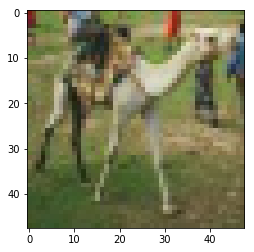

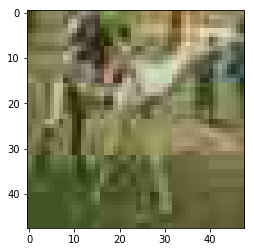

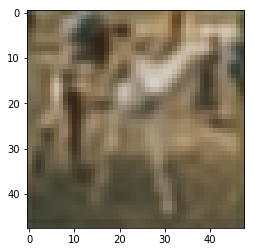

3it [00:00,  2.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


5it [00:01,  4.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


7it [00:01,  5.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


9it [00:01,  6.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


11it [00:01,  7.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


13it [00:02,  7.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


15it [00:02,  7.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


17it [00:02,  8.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


19it [00:02,  8.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


21it [00:03,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


23it [00:03,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


25it [00:03,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


27it [00:03,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


29it [00:04,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


31it [00:04,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


33it [00:04,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


35it [00:04,  8.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


37it [00:04,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


39it [00:05,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


41it [00:05,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


43it [00:05,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


45it [00:05,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


47it [00:06,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


49it [00:06,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


51it [00:06,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


53it [00:06,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


55it [00:07,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


57it [00:07,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


59it [00:07,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


61it [00:07,  8.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


63it [00:08,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


65it [00:08,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


67it [00:08,  8.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


69it [00:08,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


71it [00:09,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


73it [00:09,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


75it [00:09,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


77it [00:09,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


79it [00:09,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


81it [00:10,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


83it [00:10,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


85it [00:10,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


87it [00:10,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


89it [00:11,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


91it [00:11,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


93it [00:11,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


95it [00:11,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


97it [00:12,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


99it [00:12,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


100it [00:12,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  5 | train loss: 0.0042
decoded:  torch.Size([1, 3, 48, 48])


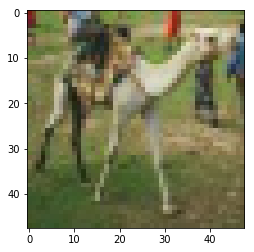

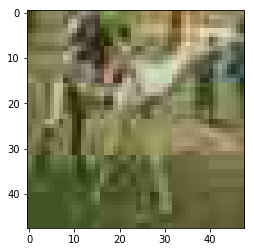

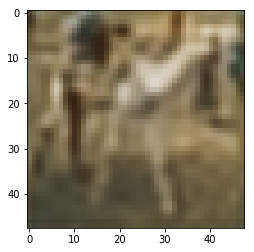

103it [00:13,  5.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


105it [00:13,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


107it [00:13,  7.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


109it [00:14,  7.97it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


111it [00:14,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


113it [00:14,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


115it [00:14,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


117it [00:14,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


119it [00:15,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


121it [00:15,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


123it [00:15,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


125it [00:15,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


127it [00:16,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


129it [00:16,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


131it [00:16,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


133it [00:16,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


135it [00:17,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


137it [00:17,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


139it [00:17,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


141it [00:17,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


143it [00:18,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


145it [00:18,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


147it [00:18,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


149it [00:18,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


151it [00:18,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


153it [00:19,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


155it [00:19,  8.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


157it [00:19,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


159it [00:19,  8.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


161it [00:20,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


163it [00:20,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


165it [00:20,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


167it [00:20,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


169it [00:21,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


171it [00:21,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


173it [00:21,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


175it [00:21,  8.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


177it [00:22,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


179it [00:22,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


181it [00:22,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


183it [00:22,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


185it [00:22,  8.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


187it [00:23,  8.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


189it [00:23,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


191it [00:23,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


193it [00:23,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


195it [00:24,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


197it [00:24,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


199it [00:24,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


200it [00:24,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  5 | train loss: 0.0046
decoded:  torch.Size([1, 3, 48, 48])


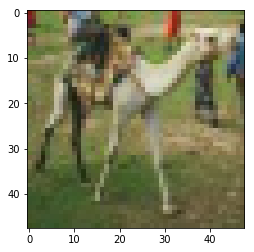

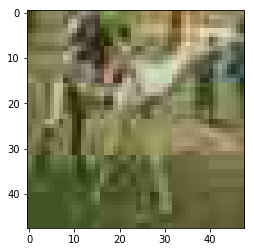

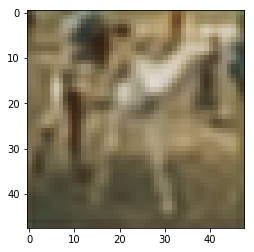

203it [00:25,  4.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


205it [00:26,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


207it [00:26,  7.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


209it [00:26,  7.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


211it [00:26,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


213it [00:26,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


215it [00:27,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


217it [00:27,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


219it [00:27,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


221it [00:27,  8.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


223it [00:28,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


225it [00:28,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


227it [00:28,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


229it [00:28,  8.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


231it [00:29,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


233it [00:29,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


235it [00:29,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


237it [00:29,  8.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


239it [00:29,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


241it [00:30,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


243it [00:30,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


245it [00:30,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


247it [00:30,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


249it [00:31,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


251it [00:31,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


253it [00:31,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


255it [00:31,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


257it [00:32,  8.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


259it [00:32,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


261it [00:32,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


263it [00:32,  8.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


265it [00:32,  8.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


267it [00:33,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


269it [00:33,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


271it [00:33,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


273it [00:33,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


275it [00:34,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


277it [00:34,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


279it [00:34,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


281it [00:34,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


283it [00:35,  8.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


285it [00:35,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


287it [00:35,  8.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


289it [00:35,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


291it [00:36,  8.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


293it [00:36,  8.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


295it [00:36,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


297it [00:36,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


299it [00:36,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


300it [00:37,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  5 | train loss: 0.0040
decoded:  torch.Size([1, 3, 48, 48])


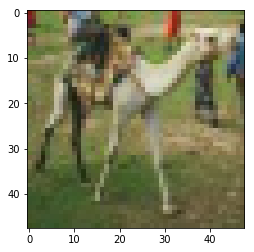

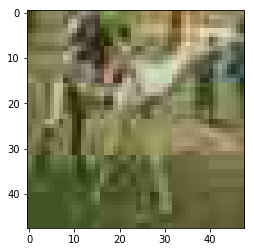

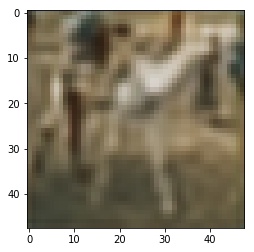

303it [00:38,  5.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


305it [00:38,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


307it [00:38,  7.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


309it [00:38,  7.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


311it [00:38,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


313it [00:39,  8.00it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


3it [00:00,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


5it [00:00,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


7it [00:00,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


9it [00:01,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


11it [00:01,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


13it [00:01,  8.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


15it [00:01,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


17it [00:02,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


19it [00:02,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


21it [00:02,  8.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


23it [00:02,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


25it [00:02,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


27it [00:03,  8.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


29it [00:03,  8.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


31it [00:03,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


33it [00:03,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


35it [00:04,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


37it [00:04,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


39it [00:04,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


41it [00:04,  8.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


43it [00:05,  8.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


45it [00:05,  8.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


47it [00:05,  8.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


49it [00:05,  8.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


51it [00:06,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


53it [00:06,  8.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


55it [00:06,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


57it [00:06,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


59it [00:07,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


61it [00:07,  8.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


63it [00:07,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


65it [00:07,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


67it [00:08,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


69it [00:08,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


71it [00:08,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


73it [00:08,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


75it [00:09,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


77it [00:09,  8.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


79it [00:09,  8.01it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


81it [00:09,  8.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


83it [00:10,  8.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


85it [00:10,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


87it [00:10,  8.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


89it [00:10,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


91it [00:11,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


93it [00:11,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


95it [00:11,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


97it [00:11,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


99it [00:11,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


101it [00:12,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


103it [00:12,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


105it [00:12,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


107it [00:12,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


109it [00:13,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


111it [00:13,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


113it [00:13,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


115it [00:13,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


117it [00:14,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


119it [00:14,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


121it [00:14,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


123it [00:14,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


125it [00:15,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


127it [00:15,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


129it [00:15,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


131it [00:15,  7.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


133it [00:16,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


135it [00:16,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


137it [00:16,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


139it [00:16,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


141it [00:17,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


143it [00:17,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


145it [00:17,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


147it [00:17,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


149it [00:17,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


151it [00:18,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


153it [00:18,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


155it [00:18,  8.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


157it [00:18,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


159it [00:19,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


161it [00:19,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


163it [00:19,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


165it [00:19,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


167it [00:20,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


169it [00:20,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


171it [00:20,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


173it [00:20,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


175it [00:21,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


177it [00:21,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


179it [00:21,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


181it [00:21,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


183it [00:21,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


185it [00:22,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


187it [00:22,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


189it [00:22,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


191it [00:22,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


193it [00:23,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


195it [00:23,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


197it [00:23,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


199it [00:23,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


201it [00:24,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


203it [00:24,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


205it [00:24,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


207it [00:24,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


209it [00:25,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


211it [00:25,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


213it [00:25,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


215it [00:25,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


217it [00:25,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


219it [00:26,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


221it [00:26,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


223it [00:26,  8.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


225it [00:26,  8.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


227it [00:27,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


229it [00:27,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


231it [00:27,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


233it [00:27,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


235it [00:28,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


237it [00:28,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


239it [00:28,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


241it [00:28,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


243it [00:29,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


245it [00:29,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


247it [00:29,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


249it [00:29,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


251it [00:30,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


253it [00:30,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


255it [00:30,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


257it [00:30,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


259it [00:30,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


261it [00:31,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


263it [00:31,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


265it [00:31,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


267it [00:31,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


269it [00:32,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


271it [00:32,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


273it [00:32,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


275it [00:32,  8.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


277it [00:33,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


279it [00:33,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


281it [00:33,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


283it [00:33,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


285it [00:34,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


287it [00:34,  8.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


289it [00:34,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


291it [00:34,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


293it [00:34,  8.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


295it [00:35,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


297it [00:35,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


299it [00:35,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


301it [00:35,  8.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


303it [00:36,  8.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


305it [00:36,  8.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


307it [00:36,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


309it [00:36,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


311it [00:37,  8.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


313it [00:37,  8.41it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


3it [00:00,  8.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


5it [00:00,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


7it [00:00,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


9it [00:01,  8.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


11it [00:01,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


13it [00:01,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


15it [00:01,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


17it [00:02,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


19it [00:02,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


21it [00:02,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


23it [00:02,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


25it [00:02,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


27it [00:03,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


29it [00:03,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


31it [00:03,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


33it [00:03,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


35it [00:04,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


37it [00:04,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


39it [00:04,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


41it [00:04,  8.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


43it [00:05,  8.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


45it [00:05,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


47it [00:05,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


49it [00:05,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


51it [00:05,  8.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


53it [00:06,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


55it [00:06,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


57it [00:06,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


59it [00:06,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


61it [00:07,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


63it [00:07,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


65it [00:07,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


67it [00:07,  8.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


69it [00:08,  8.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


71it [00:08,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


73it [00:08,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


75it [00:08,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


77it [00:09,  8.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


79it [00:09,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


81it [00:09,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


83it [00:09,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


85it [00:09,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


87it [00:10,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


89it [00:10,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


91it [00:10,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


93it [00:10,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


95it [00:11,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


97it [00:11,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


99it [00:11,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


101it [00:11,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


103it [00:12,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


105it [00:12,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


107it [00:12,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


109it [00:12,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


111it [00:13,  8.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


113it [00:13,  8.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


115it [00:13,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


117it [00:13,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


119it [00:13,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


121it [00:14,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


123it [00:14,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


125it [00:14,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


127it [00:14,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


129it [00:15,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


131it [00:15,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


133it [00:15,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


135it [00:15,  8.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


137it [00:16,  8.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


139it [00:16,  8.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


141it [00:16,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


143it [00:16,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


145it [00:16,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


147it [00:17,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


149it [00:17,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


151it [00:17,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


153it [00:17,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


155it [00:18,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


157it [00:18,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


159it [00:18,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


161it [00:18,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


163it [00:19,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


165it [00:19,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


167it [00:19,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


169it [00:19,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


171it [00:20,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


173it [00:20,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


175it [00:20,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


177it [00:20,  8.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


179it [00:20,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


181it [00:21,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


183it [00:21,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


185it [00:21,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


187it [00:21,  7.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


189it [00:22,  8.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


191it [00:22,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


193it [00:22,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


195it [00:22,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


197it [00:23,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


199it [00:23,  8.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


201it [00:23,  8.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


203it [00:23,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


205it [00:24,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


207it [00:24,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


209it [00:24,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


211it [00:24,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


213it [00:25,  8.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


215it [00:25,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


217it [00:25,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


219it [00:25,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


221it [00:26,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


223it [00:26,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


225it [00:26,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


227it [00:26,  8.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


229it [00:27,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


231it [00:27,  8.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


233it [00:27,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


235it [00:27,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


237it [00:27,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


239it [00:28,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


241it [00:28,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


243it [00:28,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


245it [00:28,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


247it [00:29,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


249it [00:29,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


251it [00:29,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


253it [00:29,  8.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


255it [00:30,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


257it [00:30,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


259it [00:30,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


261it [00:30,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


263it [00:31,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


265it [00:31,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


267it [00:31,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


269it [00:31,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


271it [00:31,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


273it [00:32,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


275it [00:32,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


277it [00:32,  7.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


279it [00:32,  8.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


281it [00:33,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


283it [00:33,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


285it [00:33,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


287it [00:33,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


289it [00:34,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


291it [00:34,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


293it [00:34,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


295it [00:34,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


297it [00:35,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


299it [00:35,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


301it [00:35,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


303it [00:35,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


305it [00:35,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


307it [00:36,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


309it [00:36,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


311it [00:36,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


313it [00:36,  8.48it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


3it [00:00,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


5it [00:00,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


7it [00:00,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


9it [00:01,  8.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


11it [00:01,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


13it [00:01,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


15it [00:01,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


17it [00:02,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


19it [00:02,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


21it [00:02,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


23it [00:02,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


25it [00:02,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


27it [00:03,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


29it [00:03,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


31it [00:03,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


33it [00:03,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


35it [00:04,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


37it [00:04,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


39it [00:04,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


41it [00:04,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


43it [00:05,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


45it [00:05,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


47it [00:05,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


49it [00:05,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


51it [00:06,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


53it [00:06,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


55it [00:06,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


57it [00:06,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


59it [00:06,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


61it [00:07,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


63it [00:07,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


65it [00:07,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


67it [00:07,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


69it [00:08,  8.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


71it [00:08,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


73it [00:08,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


75it [00:08,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


77it [00:09,  8.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


79it [00:09,  7.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


81it [00:09,  8.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


83it [00:09,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


85it [00:10,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


87it [00:10,  8.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


89it [00:10,  8.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


91it [00:10,  8.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


93it [00:11,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


95it [00:11,  8.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


97it [00:11,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


99it [00:11,  8.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


101it [00:12,  8.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


103it [00:12,  8.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


105it [00:12,  8.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


107it [00:12,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


109it [00:13,  8.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


111it [00:13,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


113it [00:13,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


115it [00:13,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


117it [00:14,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


119it [00:14,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


121it [00:14,  8.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


123it [00:14,  8.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


125it [00:15,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


127it [00:15,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


129it [00:15,  8.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


131it [00:15,  8.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


133it [00:15,  8.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


135it [00:16,  8.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


137it [00:16,  8.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


139it [00:16,  8.02it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


141it [00:16,  8.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


143it [00:17,  7.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


145it [00:17,  7.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


147it [00:17,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


149it [00:17,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


151it [00:18,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


153it [00:18,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


155it [00:18,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


157it [00:18,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


159it [00:19,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


161it [00:19,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


163it [00:19,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


165it [00:19,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


167it [00:20,  8.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


169it [00:20,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


171it [00:20,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


173it [00:20,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


175it [00:21,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


177it [00:21,  8.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


179it [00:21,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


181it [00:21,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


183it [00:21,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


185it [00:22,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


187it [00:22,  8.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


189it [00:22,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


191it [00:22,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


193it [00:23,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


195it [00:23,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


197it [00:23,  8.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


199it [00:23,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


201it [00:24,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


203it [00:24,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


205it [00:24,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


207it [00:24,  8.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


209it [00:25,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


211it [00:25,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


213it [00:25,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


215it [00:25,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


217it [00:25,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


219it [00:26,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


221it [00:26,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


223it [00:26,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


225it [00:26,  8.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


227it [00:27,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


229it [00:27,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


231it [00:27,  8.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


233it [00:27,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


235it [00:28,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


237it [00:28,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


239it [00:28,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


241it [00:28,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


243it [00:29,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


245it [00:29,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


247it [00:29,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


249it [00:29,  8.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


251it [00:30,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


253it [00:30,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


255it [00:30,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


257it [00:30,  8.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


259it [00:30,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


261it [00:31,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


263it [00:31,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


265it [00:31,  8.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


267it [00:31,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


269it [00:32,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


271it [00:32,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


273it [00:32,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


275it [00:32,  8.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


277it [00:33,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


279it [00:33,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


281it [00:33,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


283it [00:33,  8.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


285it [00:33,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


287it [00:34,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


289it [00:34,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


291it [00:34,  8.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


293it [00:34,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


295it [00:35,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


297it [00:35,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


299it [00:35,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


301it [00:35,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


303it [00:36,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


305it [00:36,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


307it [00:36,  8.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


309it [00:36,  8.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


311it [00:36,  8.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


313it [00:37,  8.42it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  9 | train loss: 0.0043
decoded:  torch.Size([1, 3, 48, 48])


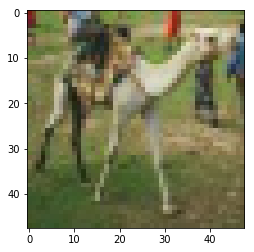

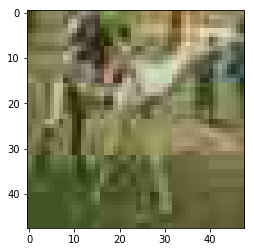

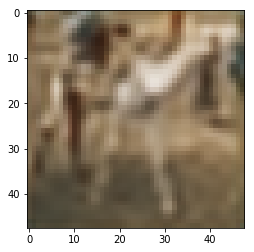

3it [00:00,  2.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


5it [00:01,  4.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


7it [00:01,  5.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


9it [00:01,  6.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


11it [00:01,  7.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


13it [00:02,  7.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


15it [00:02,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


17it [00:02,  8.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


19it [00:02,  8.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


21it [00:03,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


23it [00:03,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


25it [00:03,  8.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


27it [00:03,  8.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


29it [00:03,  8.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


31it [00:04,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


33it [00:04,  8.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


35it [00:04,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


37it [00:04,  8.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


39it [00:05,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


41it [00:05,  8.77it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


43it [00:05,  8.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


45it [00:05,  8.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


47it [00:06,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


49it [00:06,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


51it [00:06,  8.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


53it [00:06,  8.86it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


55it [00:06,  8.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


57it [00:07,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


59it [00:07,  8.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


61it [00:07,  8.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


63it [00:07,  8.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


65it [00:08,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


67it [00:08,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


69it [00:08,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


71it [00:08,  8.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


73it [00:08,  8.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


75it [00:09,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


77it [00:09,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


79it [00:09,  8.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


81it [00:09,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


83it [00:10,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


85it [00:10,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


87it [00:10,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


89it [00:10,  8.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


91it [00:11,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


93it [00:11,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


95it [00:11,  8.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


97it [00:11,  8.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


99it [00:12,  8.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


100it [00:12,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  9 | train loss: 0.0035
decoded:  torch.Size([1, 3, 48, 48])


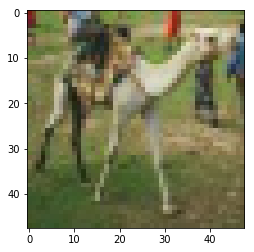

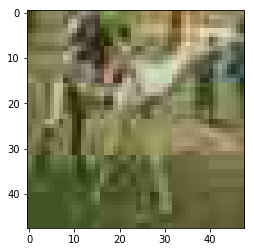

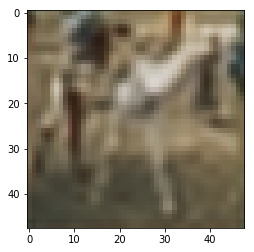

103it [00:13,  4.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


105it [00:13,  5.93it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


107it [00:13,  7.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


109it [00:13,  7.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


111it [00:14,  8.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


113it [00:14,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


115it [00:14,  8.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


117it [00:14,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


119it [00:15,  8.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


121it [00:15,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


123it [00:15,  8.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


125it [00:15,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


127it [00:16,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


129it [00:16,  8.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


131it [00:16,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


133it [00:16,  8.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


135it [00:16,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


137it [00:17,  8.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


139it [00:17,  8.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


141it [00:17,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


143it [00:17,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


145it [00:18,  8.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


147it [00:18,  8.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


149it [00:18,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


151it [00:18,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


153it [00:19,  8.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


155it [00:19,  8.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


157it [00:19,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


159it [00:19,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


161it [00:19,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


163it [00:20,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


165it [00:20,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


167it [00:20,  8.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


169it [00:20,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


171it [00:21,  8.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


173it [00:21,  8.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


175it [00:21,  8.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


177it [00:21,  8.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


179it [00:22,  8.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


181it [00:22,  8.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


183it [00:22,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


185it [00:22,  8.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


187it [00:23,  8.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


189it [00:23,  8.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


191it [00:23,  8.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


193it [00:23,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


195it [00:24,  8.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


197it [00:24,  8.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


199it [00:24,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


200it [00:24,  8.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  9 | train loss: 0.0039
decoded:  torch.Size([1, 3, 48, 48])


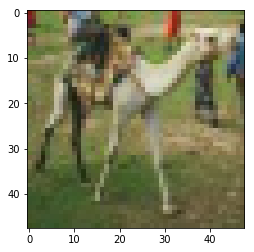

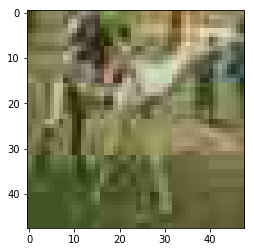

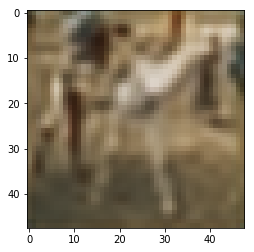

203it [00:25,  5.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


205it [00:25,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


207it [00:25,  7.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


209it [00:26,  8.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


211it [00:26,  8.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


213it [00:26,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


215it [00:26,  8.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


217it [00:27,  8.77it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


219it [00:27,  8.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


221it [00:27,  8.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


223it [00:27,  8.83it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


225it [00:28,  8.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


227it [00:28,  8.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


229it [00:28,  8.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


231it [00:28,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


233it [00:28,  8.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


235it [00:29,  8.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


237it [00:29,  8.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


239it [00:29,  8.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


241it [00:29,  8.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


243it [00:30,  8.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


245it [00:30,  8.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


247it [00:30,  8.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


249it [00:30,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


251it [00:31,  8.86it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


253it [00:31,  8.92it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


255it [00:31,  8.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


257it [00:31,  8.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


259it [00:31,  8.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


261it [00:32,  8.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


263it [00:32,  8.88it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


265it [00:32,  8.86it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


267it [00:32,  8.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


269it [00:33,  8.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


271it [00:33,  8.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


273it [00:33,  8.77it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


274it [00:33,  7.96it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


277it [00:34,  8.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


279it [00:34,  8.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


281it [00:34,  8.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


283it [00:34,  8.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


285it [00:34,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


287it [00:35,  8.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


289it [00:35,  8.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


291it [00:35,  8.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


293it [00:35,  8.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


295it [00:36,  8.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


297it [00:36,  8.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


299it [00:36,  8.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


300it [00:36,  8.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  9 | train loss: 0.0041
decoded:  torch.Size([1, 3, 48, 48])


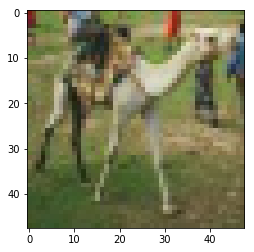

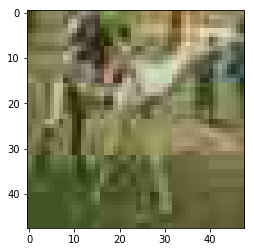

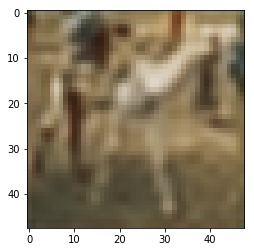

303it [00:37,  5.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


305it [00:37,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


307it [00:38,  7.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


309it [00:38,  7.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


311it [00:38,  8.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


313it [00:38,  8.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])


In [17]:

# Hyper Parameters
epochs = 10
lr = 0.005 
n_plots = 1
batch_size = 32

in_data, original_data = train_dataset.get_train_data(n_plots)
autoencoder = ConvAutoencoder(3)#AutoEncoder(latent_dim=30, image_size=48, channel_num=3)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = loss = nn.MSELoss()

autoencoder.train()
for epoch in range(epochs):
    for step, (x, y) in tqdm.tqdm(enumerate(train_loader)):
        encoded, decoded = autoencoder(x) 
#         y = y.view(-1, 3 * 48 * 48)
#         print('decoded.shape: ', decoded.shape)
#         print('y.shape: ', y.shape)

        loss = loss_func(decoded, y) 
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 100 == 0 and epoch in [0, 5, epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())      
            _, decoded_data = autoencoder(in_data)
#             print(in_data.shape)
#             print(decoded_data)
            show_img(in_data.squeeze(0))
            show_img(original_data.squeeze(0))
            show_img(decoded_data.data.squeeze(0))

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
(400, 3, 48, 48)


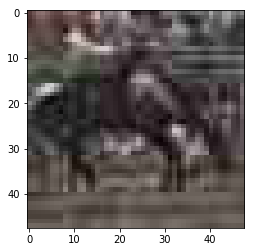

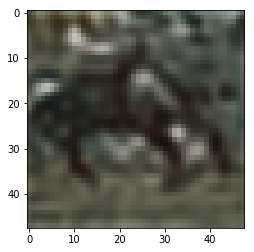

In [20]:
test_dataset = DenoisingDataset('data', 
                                train=False,
                                transform=transforms.Compose([
                                   torchvision.transforms.ToTensor()
#                                    torchvision.transforms.Lambda(lambda x: x.flatten())
                                ]))

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
decoded_samples = []
autoencoder.eval()
for step, x in enumerate(test_loader):
    
    en_x, de_x = autoencoder(x)
    decoded_samples.append(de_x.detach().numpy())
    # encode the points into the latent space and save for later estimation
    
sampled_z = np.concatenate(decoded_samples, axis=0)
print(sampled_z.shape)
save_result(sampled_z, 'solution.csv')
show_img(x[0].squeeze(0))#.view(3,48, 48))
# show_img(original_data.squeeze(0))#.view(3,48, 48))
show_img(de_x[0].data.squeeze(0))


In [0]:
torch.save(autoencoder.state_dict(), 'tmp_model.pt')

In [0]:
autoencoder.load_state_dict(torch.load('tmp_model.pt'))
